In [1]:
import pandas as pd
import os
import glob
import numpy as np
import math
import seaborn as sns
import warnings
from datetime import datetime
from numpy import inf
from dateutil.relativedelta import relativedelta
import os
import openai
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from scipy import stats

openai.api_key = #ENTER YOUR KEY HERE#

## Aggregate EOD Trading Data

In [2]:
#Backtest start date, not inclusive
backtest_start = pd.Timestamp("2016-03-10")

#Backtest end date, inclusive
backtest_end = pd.Timestamp("2021-02-11")

#Maximum amount of stocks to include in backtest
max_stock = 1000

#Find the directory of the csv Files
#Default csv files stores in folder called sp500
path = os.getcwd() + "/sp500"
csv_files = glob.glob(os.path.join(path, "*.csv"))

#Column names
#Used for compatibility reasons with different data sources.
date_col = "Date"
open_col = "open"

#Minimum price
#Sometimes, stock trade at such low value that price is 0 within data accuracy
#Leads to division by 0 problem
#Can require stock to trade above some value, otherwise discard trading day
min_price = 0.01
book_value = 1e3


#################################################################
#The data frame will be stored in tickers_df
#A dictionary with key:value as (ticker:df)
tickers_df = {}

#Read data
stock_count = 0
tickers = []

#READ IN THE FILES ONE BY ONE
for path in csv_files[:max_stock]:
    #Obtain tickers
    name = path.split("/")[-1]
    name = name[:len(name)-4]
    name = name.lower()
    
    #Read the data frame. Ensure recent dates are at bottom rows
    df = pd.read_csv(path, parse_dates = [date_col], dayfirst = False)
    if df.loc[:,date_col][0] > df.loc[:,date_col][10]:
        df = df.iloc[::-1]
    
    #Change all column names to lower case for consistency
    df.columns = df.columns.str.lower()
    
    #Filter out dates before or after backtesting date
    df = df[df[date_col.lower()] > backtest_start]
    df = df[df[date_col.lower()] < backtest_end]
    
    #Set date as index, remove from df
    df.index = df[date_col.lower()]
    df = df.drop(columns = [date_col.lower()])
    
    #Read the data frame. Filter out days when prices are below threshold
    df = df[df[open_col.lower()] > min_price]
    
    #Calculate essential fields - daily returns
    if "returns" not in df.columns:
        df["returns"] = (df["open"]-df["open"].shift(1))/df["open"].shift(1)
        
    #Calculate eseential fields - adv20
    #Average volume of the past 20 days
    if "adv20" not in df.columns:
        df["adv20"] = df["volume"].rolling(20).mean()
    
    #Drop dataframe if no entries are left.
    #Will not be included in tickers_df
    row, column = df.shape
    if row != 0:
        tickers.append(name)
        tickers_df[name] = df
        stock_count += 1
    else:
        print(name, " does not have valid trading days")

#Identify All Fields Present, Used in alpha processing
fields = []
for ticker in tickers:
    columns = tickers_df[ticker].columns
    for column in columns:
        if column not in fields: 
            fields.append(column.lower())

#Report Output
print("------------------------------------------")
print(len(csv_files), " files in the directory")
print(stock_count, " stocks is used")

ogn  does not have valid trading days
wbd  does not have valid trading days
gehc  does not have valid trading days
ceg  does not have valid trading days
------------------------------------------
502  files in the directory
498  stocks is used


## GPTGen

In [3]:
def first_conversation():

    system_prompt = """You are a finance professional with background in economics and quantitative finance. 
    Please direct your response in the form of fast expression language, as presented below"""

    first_input = """
    Here are some example "alphas", written in fast expression language.
    Alphas are algorithmic strategies that will provide return higher than the index. 
    Learn the fast expression language. Using available data fields, generate 10 new alphas

    Alpha#1: (correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6)) 
    Alpha#2: (-1*correlation(rank(open), rank(volume), 90))
    Alpha#3: (ts_rank(rank(low), 9))
    Alpha#4: rank(open)
    Alpha#5: (rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - delay((ts_sum(open, 5) * ts_sum(returns, 5)), 10))))
    Alpha#6: (sign(delta(volume, 1)) * (-1 * delta(close, 1)))
    Alpha#7: (rank(covariance(rank(close), rank(volume), 75)))
    Alpha#8: ((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))
    Alpha#9: (ts_sum(rank(correlation(rank(high), rank(volume), 3)), 3))
    Alpha#10: (-1 * rank(covariance(rank(high), rank(volume), 5)))
    Alpha#11: (((rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) * rank(ts_rank((volume / adv20), 5)))
    Alpha#12: (rank(((ts_stdev(absolute((close - open)), 5) + (close - open)) + correlation(close, open, 10))))
    Alpha#13: ((sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + ts_sum(returns, 250)))))
    Alpha#14: (((rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open - delay(low, 1))))

    MAKE SURE THE RESPONSE YOU GIVE IS IN THE FOLLOWING FORMAT:
    It should begin with "Alpha#xx"
    Followed by a colon
    And then a specific type of command or formula related to financial analysis.
    """

    first_response = """
    rank(): This orders the data points from highest to lowest and assigns a rank.
    delta(): This calculates the change between the current and a prior element.
    ts_rank(): Time-series rank over a specified window.
    ts_min() and ts_max(): Time-series minimum and maximum over a specified window.
    ts_sum(): Summation over a specified window.
    ts_stdev(): Standard deviation over a specified window.
    correlation(): Statistical correlation between two time-series.
    covariance(): Measures the directional relationship between two time-series.
    absolute(): Absolute value.
    close, open, high, low, volume: These are typical market data points."""

    second_input = """
    The available fields are:
    open: Daily open price
    high: Daily high price
    low: Daily low price
    close: Daily close price
    volume: Daily volume price
    """

    messages.append({"role": "system",
                     "content": system_prompt})
    messages_history.append({"role": "system",
                             "content": system_prompt})
    messages.append({"role": "user",
                     "content": first_input})
    messages_history.append({"role": "user",
                     "content": first_input})
    messages.append({"role": "assistant",
                     "content": first_response})
    messages_history.append({"role": "assistant",
                     "content": first_response})

    output = openai.ChatCompletion.create(
      model="gpt-4o",
      messages=messages,
      temperature=0,
      max_tokens=1024
    )
    return output

## Alpha Builder

In [4]:
#STRING PROCESSING & EXECUTION
def replace_fields(expression, fields):
    """Perform string processing"""
    # Define the pattern to match field names
    pattern = r'(?<!field\(\')\b(' + '|'.join(re.escape(field) for field in fields) + r')\b(?!\'\))'
    # Function to replace the field name with df["field"]
    def replacer(match):
        return "field('{}')".format(match.group(0))

    # Replace all occurrences of the field names in the expression
    return re.sub(pattern, replacer, expression)

def run(alpha):
    """Execute alpha"""
    alpha = replace_fields(alpha, fields)
    alpha = alpha.strip()
    return eval(alpha)

#TRANSFORMATION
def field(field):
    dflist = []
    for ticker in tickers:
        out = tickers_df[ticker][field]
        out = out.rename(ticker)
        out = out.ffill().fillna(0)
        dflist.append(out)
    return pd.concat(dflist, axis = 1, join = "outer")

def absolute(field):
    """return the absolute value of the series"""
    out = field.abs()
    return out

def sign(field):
    return field

def log(field):
    """return the log of the series"""
    out = np.log(field)
    return out

#TIME SERIES OPERATIONS
def lag(field, window = 1):
    """Return the value window day ago"""
    dflist = []
    out = field.lag(window)
    return out

def delay(field, window = 1):
    """Same as lag, return the value of the field n days ago"""
    return field.shift(window)

def ts_sum(field, window = 1):
    """return the sum of the field over the past n days"""
    out = field.rolling(window).sum()
    return out

def ts_mean(field, window = 1):
    """return the mean of the field over the past n days"""
    out = field.rolling(window).mean()
    return out

def ts_max(field, window = 1):
    out = field.rolling(window).max()
    return out

def ts_min(field, window = 1):
    out = field.rolling(window).min()
    return out

def ts_stdev(field, window = 1):
    out = field.rolling(window).std()
    return out

def ts_rank(field, window = 1):
    out = ts_mean(field, window)
    out = rank(out)
    return out
    
def delta(field, window = 1):
    out = field.diff()
    return out
    
#TIME SERIES OPERATIONS WITH TWO INPUTS
def correlation(field1, field2, window = 1):
    return field1.rolling(window).corr(field2)

def covariance(field1, field2, window = 1):
    return field1.rolling(window).cov(field2)

#HORIZONTAL OPERATORS
def rank_and_normalize(row):
    # Helper function for the rank funciton.
    # Exclude NaNs and get the rank. The method 'first' handles ties by assigning ranks in the order they appear.
    ranked = row.dropna().rank(method='first') - 1
    # Normalize the ranks to be between 0 and 1
    normalized = ranked / ranked.max()
    # Place the normalized values back into the row, preserving NaNs.
    row[row.notna()] = normalized
    return row

def rank(field):
    aggregate = field
    aggregate = aggregate.apply(rank_and_normalize, axis = 1)
    return aggregate

def constant(field):
    #Constant is mostly for debugging purpose. Use constant("open") or any other field
    #Set signal to a constant
    #The result should match index
    aggregate = field
    field.loc[:,:] = 1
    print(aggregate)
    return aggregate

def scale(field, factor = 1):
    mult = factor/(rank(field).sum())
    return rank(field) * mult

How to handle NaN values.

Let us consider the signal data frame. If the signal is missing, we use the signal from yesterday (before normalization). If the signal is missing and there is no earlier values, we replace it with 0.

Now let us consider the open data frame. If the open price is missing, we use the open price from yesterday to calculate the total stock value. 

In [5]:
def run_backtest(output, generation):
    metrics = {}
    warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
    np.seterr(divide = 'ignore')
    count = 0
    
    for alpha in output:
        metric = {}
        print("RUNNING: " + str(count), alpha)
        #Alpha Processing
        alpha = alpha.lower()
        alpha = replace_fields(alpha, fields)

        #Run Alpha
        try:
            signal = run(alpha)
        except:
            signal = run("(ts_rank(rank(low), 9))")
        
        #Deal with edge cases. If the signal is inf or -inf, discard
        #If the result is Nan. Then first try to set it to last known value.
        #If no last known value can be found, set to 0
        signal = signal.replace([np.inf, -np.inf], np.nan)
        signal = signal.ffill()
        signal = signal.fillna(0)
        signal = signal.shift(1)
        signal = signal.div(signal.abs().sum(axis=1), axis = 0)
        signal = signal * book_value

        #Aggregate Open prices
        df_list = []
        for ticker in tickers:
            df = pd.DataFrame(tickers_df[ticker][open_col.lower()])
            df = df.rename(columns={open_col.lower(): ticker})
            df_list.append(df)
        open_df = pd.concat(df_list, axis=1)
        open_df = open_df.fillna(method = "ffill")

        #Calculate Position for Each Stock
        position = (signal / open_df)
        position = position.fillna(method = "ffill")
        position = position.fillna(0)

        #Calculate Trades Executed
        trade = position.diff()

        #Rename Columns
        signal = signal.add_suffix(" signal")
        position = position.add_suffix(' position')
        trade = trade.add_suffix(' trade')
        open_df = open_df.add_suffix(" open")

        #Concatenate dataframes
        value = pd.concat([signal, open_df, position, trade], axis=1)

        #Calculate PnL
        #Use copy to avoid fragmentation issue
        value = value.copy()
        value["tsv"] = 0
        value["cv"] = 0
        value["book_size"] = 0

        #Calculate stock and cash value
        for ticker in tickers:
            stock_c = ticker + " stock value"
            cash_c = ticker + " cash value"
            trade_c = ticker + " trade"
            position_c = ticker + " position"
            open_c = ticker + " open"

            value[stock_c] = (value[position_c] * value[open_c]).ffill().fillna(0)
            value["tsv"] += value[stock_c]
            value["book_size"] += value[stock_c].abs()
            value[cash_c] = (value[trade_c] * -1 * value[open_c]).ffill().fillna(0)
            value["cv"] += value[cash_c]

        value["tcv"] = value["cv"].cumsum()
        value["pnl"] = value["tcv"] + value["tsv"]

        # Calculate return of the strategy
        portfolio = value[["tcv", "tsv", "pnl", "book_size"]]
        portfolio = portfolio.copy()

        #Capture Metrics
        metric["pnl_history"] = value["pnl"]
        metric["generation"] = generation

        ###SHARPE RATIO
        #Calculate the Sharpe Ratio (Assume 0 risk free interest)
        portfolio["return"] = portfolio["pnl"].diff()/book_value

        #Replace the inf and -inf value with 0
        portfolio[portfolio == -np.inf] = 0
        portfolio[portfolio == np.inf] = 0

        #Calculate number of trading days
        row, column = portfolio.shape

        #Calculate mean and stdev
        mean_return = portfolio["return"].mean()
        return_std = portfolio["return"].std()/math.sqrt(row)

        #Calculate the Sharpe Ratio (0 risk free rate)
        sharpe_ratio = mean_return/return_std
        metric["zero risk-free sharpe"] = sharpe_ratio

        #PnL
        metric["pnl"] = portfolio["pnl"].iloc[-1]

        #Append alpha for record keeping
        metric["alpha"] = alpha

        ###TURNOVER RATIO
        value_bought = 0
        value_sold = 0

        for ticker in tickers:
            transaction = value[ticker + " trade"] * value[ticker + " open"]
            positive = transaction[transaction > 0]
            negative = transaction[transaction < 0]
            value_bought += sum(positive)
            value_sold += sum(negative * -1)

        num = min(value_bought, value_sold)
        turnover = num/book_value
        metric["turnover"] = turnover

        ### RETURN
        #First, find out how many years are between start of backtest to end
        duration = backtest_end - backtest_start
        year = duration.total_seconds()/(365.25*24*60*60)

        annual_return = (value["pnl"][-1]/year)/(0.5*book_value)
        metric["return"] = annual_return

        ###FITNESS
        fitness = sharpe_ratio * math.sqrt(abs(annual_return)/max(turnover, 0.125))
        metric["fitness"] = fitness

        ###MARGIN
        margin = value["pnl"][-1] / (sum(abs(positive)) + sum(abs(negative)))
        metric["margin"] = margin
        metrics[count] = metric

        #Reporting
        tup = [x for x in metric.items()]
        for cat, value in tup:
            if cat != "pnl_history":
                print(f"{cat : <25}{value : >25}")

        del signal, position, trade, value, portfolio

        print("++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++")
        count += 1
        
    return metrics
    

In [19]:
#Create a score function from the dictionary
def score_function_1(dictionary):
    """Rank risk-free Sharpe (descending) and turnover (ascending).
       The score function is the sum of the rank. Lower is better
       The input is one generation of evolution"""
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(dictionary, orient='index')
    
    # Rank Sharpe values (descending) and turnover values (ascending)
    df['sharpe_rank'] = df['zero risk-free sharpe'].rank(ascending=False)
    df['turnover_rank'] = df['turnover'].rank(ascending=True)
    
    # Sum the ranks for each strategy
    df['total_rank'] = df['sharpe_rank'] + df['turnover_rank']
    
    # Convert the total rank back to a dictionary
    total_ranks = df['total_rank'].to_dict()
    
    return total_ranks

def score_function_2(dictionary):
    """Rank risk-free Sharpe (descending), turnover (ascending), 
       and correlations with pnl_good_performer (lower is better).
       The score function is the sum of all ranks. Lower is better"""
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame.from_dict(dictionary, orient='index')
    
    # Calculate ranks for Sharpe and turnover
    df['sharpe_rank'] = df['zero risk-free sharpe'].rank(ascending=False)
    df['turnover_rank'] = df['turnover'].rank(ascending=True)
    
    max_correlations = []
    for pnl_history in df['pnl_history']:
        correlations = []
        for pnl_performer in pnl_good_performer:
            correlation = pd.Series(pnl_history).corr(pd.Series(pnl_performer))
            correlations.append(correlation)
        max_correlations.append(max(correlations))
    
    df["max_correlation"] = max_correlations
    df["correlation_rank"] = df["max_correlation"].rank(ascending = True)
    
    # Sum all ranks
    df['total_rank'] = df['sharpe_rank'] + df['turnover_rank'] + df['correlation_rank']*2
    print(df)
    # Convert the total rank back to a dictionary
    total_ranks = df['total_rank'].to_dict()
    
    return total_ranks


## Running a New Evolution

In [21]:
#Many Generation of Evolution
generation = 20 #Number of generations
metric_generations = []
messages = []
pnl_good_performer = []
top_performers = []
second_performers = []
third_performers = []
messages_history = []
worst_performers = []
second_worst_performers = []
third_worst_performers = []

#Prepopulate pnl_good_performer
alpha = "(-1 * Ts_Rank(rank(low), 9))"
output = alpha.split("\n")
pattern = r'Alpha#\d+:'
output = [re.sub(pattern, '', string).strip() for string in output]
pnl_good_performer.append(run_backtest(output,-1)[0]["pnl_history"])

alpha = "(-1 * correlation(rank(open), rank(volume), 10))"
output = alpha.split("\n")
pattern = r'Alpha#\d+:'
output = [re.sub(pattern, '', string).strip() for string in output]
pnl_good_performer.append(run_backtest(output,-1)[0]["pnl_history"])

alpha = "(-1 * correlation(rank(close), rank(volume), 30))"
output = alpha.split("\n")
pattern = r'Alpha#\d+:'
output = [re.sub(pattern, '', string).strip() for string in output]
pnl_good_performer.append(run_backtest(output,-1)[0]["pnl_history"])


def evolution(output, i):
    output = output["choices"][0]["message"]["content"]
    messages.append({"role": "assistant",
                     "content": output})
    messages_history.append({"role": "assistant",
                     "content": output})
    #Process the output. Result the ALpha#: prefix. Split by new line
    output = output.split("\n\n")
    pattern = r'Alpha#\d+:'
    output = [re.sub(pattern, '', string).strip() for string in output]

    metrics = run_backtest(output, i)
    metric_generations.append(metrics)
    
    ####### SPECIFY SCORE FUNCTION
    score = score_function_1(metrics)
    score = sorted(score.items(), key = lambda item: item[1])

    (top_performer, _) = score[0]
    pnl_good_performer.append(metrics[top_performer]["pnl_history"])
    top_performer = metrics[top_performer]["alpha"]

    (second_performer, _) = score[1]
    pnl_good_performer.append(metrics[second_performer]["pnl_history"])
    second_performer = metrics[second_performer]["alpha"]

    follow_up = top_performer + " and " + second_performer + """ performed well in the backtesting based on turnover and Sharpe. 
    Can you generate TEN MORE alpha ideas similar to these two? 
    Make sure the response you give is in the following format: It should begin with "Alpha#xx", Followed by a colon,
    And then a specific alpha idea written in fast expression language."""

    print("+"*75)
    print("Round " + str(i) + " completed, top performers were \n", top_performer + "\n" + second_performer)

    messages.append({"role": "user",
                     "content": follow_up})
    messages_history.append({"role": "user",
                     "content": follow_up})
    return None

def evolution_2(output, i):
    output = output["choices"][0]["message"]["content"]
    messages.append({"role": "assistant",
                     "content": output})
    messages_history.append({"role": "assistant",
                     "content": output})
    #Process the output. Result the ALpha#: prefix. Split by new line
    output = output.split("\n\n")
    pattern = r'Alpha#\d+:'
    output = [
        re.sub(pattern, '', string).strip() 
        for string in output 
        if re.match(pattern, string)
    ]

    metrics = run_backtest(output, i)
    metric_generations.append(metrics)
    
    ####### SPECIFY SCORE FUNCTION
    score = score_function_2(metrics)
    score = sorted(score.items(), key = lambda item: item[1])

    (top_performer, _) = score[0]
    pnl_good_performer.append(metrics[top_performer]["pnl_history"])
    top_alpha = metrics[top_performer]["alpha"]
    top_performers.append({top_alpha:metrics[top_performer]})

    (second_performer, _) = score[1]
    pnl_good_performer.append(metrics[second_performer]["pnl_history"])
    second_alpha = metrics[second_performer]["alpha"]
    second_performers.append({second_alpha:metrics[second_performer]})
    
    (third_performer, _) = score[2]
    pnl_good_performer.append(metrics[third_performer]["pnl_history"])
    third_alpha = metrics[third_performer]["alpha"]
    third_performers.append({third_alpha:metrics[third_performer]})
    
    (worst_performer, _) = score[9]
    worst_alpha = metrics[worst_performer]["alpha"]
    worst_performers.append({worst_alpha:metrics[worst_performer]})
    
    (second_worst_performer, _) = score[8]
    second_worst_alpha = metrics[second_worst_performer]["alpha"]
    second_worst_performers.append({second_worst_alpha:metrics[second_worst_performer]})
    
    (third_worst_performer, _) = score[7]
    third_worst_alpha = metrics[third_worst_performer]["alpha"]
    third_worst_performers.append({third_worst_alpha:metrics[third_worst_performer]})

    follow_up = top_alpha + ", " + second_alpha + " and " + third_alpha + " performed best, second-best, and third-best in the backtesting, respectively." + \
    worst_alpha + ", " + second_worst_alpha + ", " + third_worst_alpha + """performed worst, second-to-worst, and third-to-worst in the backtesting, respectively. 
    I want you to reflect on what makes the best-performing alphas good and the worst-performing alphas bad. Using this insight, generate ten more good-performing alpha ideas.
    In addition, I want fifteen alpha ideas that is COMPLETELY UNRELATED to the previous best performers. Use different ideas, different nesting of function. It needs to be very different.
    Make sure you use different fields. Increase the variety of alpha ideas produced.
    Do not simply change the values of the parameters but try to come up with novel ideas.
    Give the ten good ideas first before the ten unrelated ideas.
    Make sure the response you give is in the following format: It should begin with "Alpha#xx", Followed by a colon,
    And then a specific alpha idea written in fast expression language. Between each alpha are two newline characters"""

    print("+"*75)
    print("Round " + str(i) + " completed, top performers were \n", top_alpha + "\n" + second_alpha + "\n" + third_alpha)

    messages.append({"role": "user",
                     "content": follow_up})
    messages_history.append({"role": "user",
                     "content": follow_up})
    return None

for i in range(generation):
    if i == 0:
        #Teach GPT Fast Expression, Generate First Alpha
        output = first_conversation()
        
        ###Specify type of Evolution
        evolution_2(output, i)
    if i <=8:
        output = openai.ChatCompletion.create(
          model="gpt-4o",
          messages=messages,
          temperature=0,
          max_tokens=1024
        )
        
        #Teach GPT Fast Expression, Generate First Alpha
        evolution_2(output,i)
    else:
        output = openai.ChatCompletion.create(
          model="gpt-4o",
          messages=messages,
          temperature=0,
          max_tokens=1024
        )
        
        #Teach GPT Fast Expression, Generate First Alpha
        evolution_2(output,i)
        del messages[3] #Remove earlier messages to keep context token length in limit
        del messages[4]
    

RUNNING: 0 (-1 * Ts_Rank(rank(low), 9))
generation                                      -1
zero risk-free sharpe           -2.384596517064562
pnl                              -926.500453926356
alpha                    (-1 * ts_rank(rank(field('low')), 9))
turnover                         8.637596856214017
return                          -0.376213775204671
fitness                       -0.49766349684960354
margin                          -97.50445756799247
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 0 (-1 * correlation(rank(open), rank(volume), 10))
generation                                      -1
zero risk-free sharpe         -0.37735436971250785
pnl                             -48.42358141056714
alpha                    (-1 * correlation(rank(field('open')), rank(field('volume')), 10))
turnover                        281.58832427668864
return                       -0.019662827248704443
fitness                     -0.0031532982050007487

RUNNING: 0 (rank(correlation(rank(field('close')), rank(field('volume')), 20)))
generation                                       0
zero risk-free sharpe           2.3320108455189206
pnl                              945.5690891572858
alpha                    (rank(correlation(rank(field('close')), rank(field('volume')), 20)))
turnover                          78.7651554359053
return                         0.38395676466336703
fitness                        0.16281884155418644
margin                          3.1777430872461374
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('open'), 1), 7)))
generation                                       0
zero risk-free sharpe            2.219564595828506
pnl                              920.6487539020002
alpha                    (rank(ts_min(delta(field('open'), 1), 7)))
turnover                         74.68622317628356
return                           0.373837640203119
fitness  

generation                                       0
zero risk-free sharpe           2.3305114493418158
pnl                              895.7582140014159
alpha                    (rank(ts_min(field('low'), 25)))
turnover                         8.610075511893415
return                          0.3637306144124704
fitness                         0.4790023993525466
margin                            98.8416272299031
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 15 (rank(correlation(field('high'), field('low'), 10)))
generation                                       0
zero risk-free sharpe            2.150081421763643
pnl                              959.1253312623769
alpha                    (rank(correlation(field('high'), field('low'), 10)))
turnover                        125.90140512017071
return                         0.38946139771382227
fitness                        0.11958365607219917
margin                          1.9523317127478732
++

RUNNING: 0 (rank(ts_min(field('close'), 20)))
generation                                       1
zero risk-free sharpe            2.347838373373032
pnl                              904.4677998522695
alpha                    (rank(ts_min(field('close'), 20)))
turnover                         8.587861124897309
return                         0.36726721945085206
fitness                         0.4855307873599956
margin                           95.83910204019696
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(correlation(rank(field('low')), rank(field('volume')), 25)))
generation                                       1
zero risk-free sharpe           2.3430906879082487
pnl                              942.6204182566189
alpha                    (rank(correlation(rank(field('low')), rank(field('volume')), 25)))
turnover                         67.20168324041843
return                          0.3827594305372207
fitness                      

generation                                       1
zero risk-free sharpe            2.069573780283251
pnl                              861.8221949778036
alpha                    (rank(correlation(field('low'), field('volume'), 5)))
turnover                        225.86317223439033
return                         0.34995059112356064
fitness                        0.08146321908468639
margin                          0.9513170897750226
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('open'), 10)))
generation                                       1
zero risk-free sharpe             2.36893932429857
pnl                              922.0924740431655
alpha                    (rank(ts_rank(field('open'), 10)))
turnover                         8.753950592737738
return                          0.3744238756467662
fitness                        0.48992957734593745
margin                           97.51194784635017
+++++++++++++++++

RUNNING: 0 (rank(ts_min(delta(field('close'), 1), 15)))
generation                                       2
zero risk-free sharpe            2.344862844535411
pnl                              975.8944587400381
alpha                    (rank(ts_min(delta(field('close'), 1), 15)))
turnover                        33.992271471614956
return                          0.3962706515339621
fitness                         0.2531764502068932
margin                           9.973714710711993
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('open'), 1), 25)))
generation                                       2
zero risk-free sharpe           2.2651914370274016
pnl                              943.2260963144871
alpha                    (rank(ts_min(delta(field('open'), 1), 25)))
turnover                         23.14138458330154
return                         0.38300537151624947
fitness                         0.2914155175210526
marg

generation                                       2
zero risk-free sharpe            2.089359678716972
pnl                              936.7180785003304
alpha                    (rank(correlation(field('high'), field('close'), 10)))
turnover                        119.62627276702524
return                          0.3803627328207289
fitness                        0.11781454301856377
margin                            2.03534321049094
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 15)))
generation                                       2
zero risk-free sharpe           2.1950011875206696
pnl                              958.5013720141858
alpha                    (rank(ts_rank(field('volume'), 15)))
turnover                        14.595042468046643
return                         0.38920803349436506
fitness                         0.3584453707442097
margin                          17.448894791425246
++++++++++++

RUNNING: 0 (rank(ts_min(delta(field('close'), 1), 10)))
generation                                       3
zero risk-free sharpe           2.3349793785978408
pnl                              970.4770334823628
alpha                    (rank(ts_min(delta(field('close'), 1), 10)))
turnover                        49.760426859802244
return                          0.3940708576758566
fitness                         0.2077916828803547
margin                           6.648664071501199
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(delta(field('high'), 3)))
generation                                       3
zero risk-free sharpe            2.281102733187806
pnl                              938.2756830792406
alpha                    (rank(delta(field('high'), 3)))
turnover                         372.6573000023876
return                         0.38099521205635645
fitness                        0.07293731760125292
margin                      

generation                                       3
zero risk-free sharpe           2.0884102610741153
pnl                              914.9149871260324
alpha                    (rank(correlation(field('low'), field('close'), 5)))
turnover                        218.69770500850217
return                         0.37150939304923103
fitness                        0.08607531187030441
margin                          1.0475222250206901
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('open'), 20)))
generation                                       3
zero risk-free sharpe           2.3400701508452624
pnl                               910.751811501916
alpha                    (rank(ts_rank(field('open'), 20)))
turnover                         8.503792590625151
return                         0.36981889844477467
fitness                         0.4879969388187952
margin                          107.46663536260311
++++++++++++++++++

RUNNING: 0 (rank(delta(field('close'), 3)))
generation                                       4
zero risk-free sharpe           2.1357730867844724
pnl                              883.8790401867892
alpha                    (rank(delta(field('close'), 3)))
turnover                        397.82657050183064
return                         0.35890696990352944
fitness                        0.06415036958684774
margin                          0.6918349555085461
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('open'), 1), 10)))
generation                                       4
zero risk-free sharpe           2.3191258494585822
pnl                              963.1657300379649
alpha                    (rank(ts_min(delta(field('open'), 1), 10)))
turnover                         50.34469508029988
return                          0.3911020376835649
fitness                          0.204405462944807
margin                      

generation                                       4
zero risk-free sharpe           2.2284179363737593
pnl                              975.2302063180578
alpha                    (rank(ts_rank(field('volume'), 10)))
turnover                         17.75450814042075
return                          0.3960009259118072
fitness                        0.33280544520717587
margin                          15.127077162720221
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_stdev(field('open'), 30)))
generation                                       4
zero risk-free sharpe           2.2253689665041816
pnl                              940.0144655681885
alpha                    (rank(ts_stdev(field('open'), 30)))
turnover                        21.277867708587767
return                          0.3817012601987558
fitness                         0.2980573062152692
margin                          23.740391620584735
++++++++++++++++++++++++++++++++

RUNNING: 0 (rank(ts_min(delta(field('high'), 1), 15)))
generation                                       5
zero risk-free sharpe            2.357183149274684
pnl                              976.9126112762165
alpha                    (rank(ts_min(delta(field('high'), 1), 15)))
turnover                         35.44255538244718
return                          0.3966840814548505
fitness                        0.24937516534319693
margin                           9.189512249981654
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('low'), 1), 10)))
generation                                       5
zero risk-free sharpe             2.29644125299047
pnl                              954.4181233111399
alpha                    (rank(ts_min(delta(field('low'), 1), 10)))
turnover                          53.2976549520259
return                          0.3875499939292872
fitness                        0.19582365695685114
margin  

generation                                       5
zero risk-free sharpe           2.1950011875206696
pnl                              958.5013720141858
alpha                    (rank(ts_rank(field('volume'), 15)))
turnover                        14.595042468046643
return                         0.38920803349436506
fitness                         0.3584453707442097
margin                          17.448894791425246
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_stdev(field('open'), 25)))
generation                                       5
zero risk-free sharpe            2.262660045339808
pnl                              957.3058053226632
alpha                    (rank(ts_stdev(field('open'), 25)))
turnover                         24.32495656949583
return                          0.3887225629728769
fitness                         0.2860310273723743
margin                           20.13701517725547
++++++++++++++++++++++++++++++++

RUNNING: 0 (rank(ts_min(delta(field('volume'), 1), 15)))
generation                                       6
zero risk-free sharpe           2.4507024259878625
pnl                              972.1311942800753
alpha                    (rank(ts_min(delta(field('volume'), 1), 15)))
turnover                        29.875262310876842
return                         0.39474254442556694
fitness                          0.281703138261806
margin                           9.530023599589416
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('low'), 1), 20)))
generation                                       6
zero risk-free sharpe           2.3505710903766257
pnl                              979.3760545005831
alpha                    (rank(ts_min(delta(field('low'), 1), 20)))
turnover                        28.301593686634096
return                          0.3976843845540166
fitness                         0.2786359915796531
marg

generation                                       6
zero risk-free sharpe            2.150081421763643
pnl                              959.1253312623769
alpha                    (rank(correlation(field('high'), field('low'), 10)))
turnover                        125.90140512017071
return                         0.38946139771382227
fitness                        0.11958365607219917
margin                          1.9523317127478732
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 15)))
generation                                       6
zero risk-free sharpe           2.1950011875206696
pnl                              958.5013720141858
alpha                    (rank(ts_rank(field('volume'), 15)))
turnover                        14.595042468046643
return                         0.38920803349436506
fitness                         0.3584453707442097
margin                          17.448894791425246
++++++++++++++

RUNNING: 0 (rank(ts_min(delta(field('low'), 1), 20)))
generation                                       7
zero risk-free sharpe           2.3505710903766257
pnl                              979.3760545005831
alpha                    (rank(ts_min(delta(field('low'), 1), 20)))
turnover                        28.301593686634096
return                          0.3976843845540166
fitness                         0.2786359915796531
margin                          11.262628901889483
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('open'), 1), 20)))
generation                                       7
zero risk-free sharpe           2.3471159263086028
pnl                               976.521804918576
alpha                    (rank(ts_min(delta(field('open'), 1), 20)))
turnover                         26.97984304248364
return                          0.3965253910467036
fitness                         0.2845445894388042
margin  

generation                                       7
zero risk-free sharpe            2.089701923101994
pnl                              868.0846473151464
alpha                    (rank(correlation(field('high'), field('volume'), 5)))
turnover                        226.19510300949005
return                          0.3524935157663782
fitness                        0.08249323014003929
margin                          0.9492227298582452
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('low'), 20)))
generation                                       7
zero risk-free sharpe           2.3397363412785954
pnl                              909.6176076161338
alpha                    (rank(ts_rank(field('low'), 20)))
turnover                         8.422612165139048
return                         0.36935834483801316
fitness                        0.48996772892194546
margin                          107.30990960306627
++++++++++++++++++

RUNNING: 0 (rank(ts_min(delta(field('open'), 1), 30)))
generation                                       8
zero risk-free sharpe             2.25595828523392
pnl                              940.2756861584046
alpha                    (rank(ts_min(delta(field('open'), 1), 30)))
turnover                        20.344580808785917
return                          0.3818073311499247
fitness                        0.30905005378645156
margin                          14.154362457682689
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('low'), 1), 25)))
generation                                       8
zero risk-free sharpe            2.268486866678593
pnl                              944.7483727355968
alpha                    (rank(ts_min(delta(field('low'), 1), 25)))
turnover                        24.148579945956634
return                          0.3836235054382176
fitness                         0.2859190389659295
margin  

generation                                       8
zero risk-free sharpe            2.120060743474193
pnl                              925.2547401390643
alpha                    (rank(correlation(field('high'), field('low'), 5)))
turnover                         220.8156596180307
return                          0.3757079420075522
fitness                         0.0874497470633243
margin                           1.023329473433142
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 10)))
generation                                       8
zero risk-free sharpe           2.2284179363737593
pnl                              975.2302063180578
alpha                    (rank(ts_rank(field('volume'), 10)))
turnover                         17.75450814042075
return                          0.3960009259118072
fitness                        0.33280544520717587
margin                          15.127077162720221
+++++++++++++++

RUNNING: 0 (rank(ts_min(field('high'), 20)))
generation                                       9
zero risk-free sharpe            2.349337212224068
pnl                              906.3389616990461
alpha                    (rank(ts_min(field('high'), 20)))
turnover                          8.74620281451752
return                          0.3680270214125365
fitness                        0.48192054259122585
margin                           93.87423961448803
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(delta(field('close'), 1), 30)))
generation                                       9
zero risk-free sharpe            2.258131479379449
pnl                              940.5471396053522
alpha                    (rank(ts_min(delta(field('close'), 1), 30)))
turnover                        20.128070624445797
return                         0.38191755724386306
fitness                         0.3110519750057353
margin                  

generation                                       9
zero risk-free sharpe           2.1129954879770776
pnl                              913.7209395176515
alpha                    (rank(correlation(field('high'), field('close'), 5)))
turnover                        215.08897396395656
return                          0.3710245393650052
fitness                        0.08775882766290727
margin                          1.0029027728521944
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 10)))
generation                                       9
zero risk-free sharpe           2.2284179363737593
pnl                              975.2302063180578
alpha                    (rank(ts_rank(field('volume'), 10)))
turnover                         17.75450814042075
return                          0.3960009259118072
fitness                        0.33280544520717587
margin                          15.127077162720221
+++++++++++++

RUNNING: 0 (rank(ts_min(field('close'), 30)))
generation                                      10
zero risk-free sharpe            2.319696680772832
pnl                              891.9885403244012
alpha                    (rank(ts_min(field('close'), 30)))
turnover                         8.481509931940831
return                          0.3621999047843108
fitness                         0.4793677129587874
margin                          100.52585961779685
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(field('volume'), 25)))
generation                                      10
zero risk-free sharpe            2.187770659492528
pnl                              948.2680796366575
alpha                    (rank(ts_min(field('volume'), 25)))
turnover                        13.171958048298858
return                         0.38505271382689177
fitness                        0.37405608023147374
margin                          18.14398

generation                                      10
zero risk-free sharpe            2.120060743474193
pnl                              925.2547401390643
alpha                    (rank(correlation(field('high'), field('low'), 5)))
turnover                         220.8156596180307
return                          0.3757079420075522
fitness                         0.0874497470633243
margin                           1.023329473433142
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 15)))
generation                                      10
zero risk-free sharpe           2.1950011875206696
pnl                              958.5013720141858
alpha                    (rank(ts_rank(field('volume'), 15)))
turnover                        14.595042468046643
return                         0.38920803349436506
fitness                         0.3584453707442097
margin                          17.448894791425246
+++++++++++++++

RUNNING: 0 (rank(ts_sum(field('high'), 20)))
generation                                      11
zero risk-free sharpe            2.340238370495378
pnl                              911.2340426972185
alpha                    (rank(ts_sum(field('high'), 20)))
turnover                         8.433336971242035
return                         0.37001471272391223
fitness                         0.4901961154626664
margin                          109.97310098694534
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_rank(field('close'), 10)))
generation                                      11
zero risk-free sharpe              2.3674877659214
pnl                              920.8621089543229
alpha                    (rank(ts_rank(field('close'), 10)))
turnover                         8.487693503798837
return                           0.373924274925588
fitness                        0.49691800078295734
margin                          101.476059

generation                                      11
zero risk-free sharpe            2.150081421763643
pnl                              959.1253312623769
alpha                    (rank(correlation(field('high'), field('low'), 10)))
turnover                        125.90140512017071
return                         0.38946139771382227
fitness                        0.11958365607219917
margin                          1.9523317127478732
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 15)))
generation                                      11
zero risk-free sharpe           2.1950011875206696
pnl                              958.5013720141858
alpha                    (rank(ts_rank(field('volume'), 15)))
turnover                        14.595042468046643
return                         0.38920803349436506
fitness                         0.3584453707442097
margin                          17.448894791425246
++++++++++++++

RUNNING: 0 (rank(ts_sum(field('low'), 20)))
generation                                      12
zero risk-free sharpe           2.3397363412785954
pnl                              909.6176076161338
alpha                    (rank(ts_sum(field('low'), 20)))
turnover                         8.422612165139048
return                         0.36935834483801316
fitness                        0.48996772892194546
margin                          107.30990960306627
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_max(field('high'), 25)))
generation                                      12
zero risk-free sharpe           2.3108852336325274
pnl                              906.9019543157441
alpha                    (rank(ts_max(field('high'), 25)))
turnover                         8.537124557926445
return                         0.36825562958735464
fitness                        0.47995140337707315
margin                          115.355934886489

generation                                      12
zero risk-free sharpe            2.120060743474193
pnl                              925.2547401390643
alpha                    (rank(correlation(field('high'), field('low'), 5)))
turnover                         220.8156596180307
return                          0.3757079420075522
fitness                         0.0874497470633243
margin                           1.023329473433142
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 15)))
generation                                      12
zero risk-free sharpe           2.1950011875206696
pnl                              958.5013720141858
alpha                    (rank(ts_rank(field('volume'), 15)))
turnover                        14.595042468046643
return                         0.38920803349436506
fitness                         0.3584453707442097
margin                          17.448894791425246
+++++++++++++++

RUNNING: 0 (rank(ts_rank(field('high'), 10)))
generation                                      13
zero risk-free sharpe           2.3684436771321145
pnl                              922.2559115508417
alpha                    (rank(ts_rank(field('high'), 10)))
turnover                          8.60860614763633
return                          0.3744902409048859
fitness                        0.49398856323106094
margin                           99.13349261434351
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(field('volume'), 15)))
generation                                      13
zero risk-free sharpe           2.1899503669555234
pnl                              953.0870069756766
alpha                    (rank(ts_min(field('volume'), 15)))
turnover                        16.113282061711036
return                         0.38700948226555404
fitness                        0.33939314819189365
margin                           15.9034

generation                                      13
zero risk-free sharpe            2.120060743474193
pnl                              925.2547401390643
alpha                    (rank(correlation(field('high'), field('low'), 5)))
turnover                         220.8156596180307
return                          0.3757079420075522
fitness                         0.0874497470633243
margin                           1.023329473433142
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 15)))
generation                                      13
zero risk-free sharpe           2.1950011875206696
pnl                              958.5013720141858
alpha                    (rank(ts_rank(field('volume'), 15)))
turnover                        14.595042468046643
return                         0.38920803349436506
fitness                         0.3584453707442097
margin                          17.448894791425246
+++++++++++++++

RUNNING: 0 (rank(ts_max(field('high'), 20)))
generation                                      14
zero risk-free sharpe           2.3326042456736023
pnl                              914.4817494979654
alpha                    (rank(ts_max(field('high'), 20)))
turnover                         8.602472590045634
return                          0.3713334730451716
fitness                        0.48463130343606503
margin                          108.18784141656964
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(field('open'), 20)))
generation                                      14
zero risk-free sharpe           2.3505316562801726
pnl                              906.1394905901088
alpha                    (rank(ts_min(field('open'), 20)))
turnover                         8.881685599728055
return                          0.3679460243891464
fitness                        0.47842125292612614
margin                           88.9723290398

generation                                      14
zero risk-free sharpe            2.089701923101994
pnl                              868.0846473151464
alpha                    (rank(correlation(field('high'), field('volume'), 5)))
turnover                        226.19510300949005
return                          0.3524935157663782
fitness                        0.08249323014003929
margin                          0.9492227298582452
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('low'), 15)))
generation                                      14
zero risk-free sharpe           2.3156067414974366
pnl                              899.6672202863582
alpha                    (rank(ts_rank(field('low'), 15)))
turnover                         8.490501969334316
return                          0.3653179012891521
fitness                         0.4803232385225602
margin                          103.04069250714821
++++++++++++++++++

RUNNING: 0 (rank(ts_min(field('close'), 30)))
generation                                      15
zero risk-free sharpe            2.319696680772832
pnl                              891.9885403244012
alpha                    (rank(ts_min(field('close'), 30)))
turnover                         8.481509931940831
return                          0.3621999047843108
fitness                         0.4793677129587874
margin                          100.52585961779685
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(field('low'), 25)))
generation                                      15
zero risk-free sharpe           2.3305114493418158
pnl                              895.7582140014159
alpha                    (rank(ts_min(field('low'), 25)))
turnover                         8.610075511893415
return                          0.3637306144124704
fitness                         0.4790023993525466
margin                            98.841627229

generation                                      15
zero risk-free sharpe            2.069573780283251
pnl                              861.8221949778036
alpha                    (rank(correlation(field('low'), field('volume'), 5)))
turnover                        225.86317223439033
return                         0.34995059112356064
fitness                        0.08146321908468639
margin                          0.9513170897750226
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('close'), 15)))
generation                                      15
zero risk-free sharpe           2.3155656612429985
pnl                              900.2238493623295
alpha                    (rank(ts_rank(field('close'), 15)))
turnover                          8.41558606750275
return                         0.36554392549148507
fitness                        0.48259709489205826
margin                           106.6520572888052
+++++++++++++++

RUNNING: 0 (rank(ts_min(field('close'), 25)))
generation                                      16
zero risk-free sharpe           2.3292479415653116
pnl                              896.4880352708828
alpha                    (rank(ts_min(field('close'), 25)))
turnover                         8.530209900079736
return                          0.3640269648501278
fitness                         0.4811745388620879
margin                           98.57421702775852
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_rank(field('low'), 15)))
generation                                      16
zero risk-free sharpe           2.3156067414974366
pnl                              899.6672202863582
alpha                    (rank(ts_rank(field('low'), 15)))
turnover                         8.490501969334316
return                          0.3653179012891521
fitness                         0.4803232385225602
margin                          103.04069250

generation                                      16
zero risk-free sharpe            2.078066039013524
pnl                              865.0248045295348
alpha                    (rank(correlation(field('close'), field('volume'), 5)))
turnover                         218.9766087506983
return                         0.35125103930451645
fitness                        0.08322796791194222
margin                          0.9757406807400562
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('low'), 10)))
generation                                      16
zero risk-free sharpe            2.368051707818794
pnl                              920.5043245367405
alpha                    (rank(ts_rank(field('low'), 10)))
turnover                         8.600905633110537
return                         0.37377899337081094
fitness                        0.49365840412212836
margin                           97.93686317083373
+++++++++++++++++

RUNNING: 0 (rank(ts_rank(field('low'), 20)))
generation                                      17
zero risk-free sharpe           2.3397363412785954
pnl                              909.6176076161338
alpha                    (rank(ts_rank(field('low'), 20)))
turnover                         8.422612165139048
return                         0.36935834483801316
fitness                        0.48996772892194546
margin                          107.30990960306627
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_sum(field('close'), 20)))
generation                                      17
zero risk-free sharpe           2.3396406868587465
pnl                              910.1234263654544
alpha                    (rank(ts_sum(field('close'), 20)))
turnover                         8.367262163519424
return                         0.36956373705389906
fitness                          0.491702200637465
margin                          110.43442853

generation                                      17
zero risk-free sharpe            2.120060743474193
pnl                              925.2547401390643
alpha                    (rank(correlation(field('high'), field('low'), 5)))
turnover                         220.8156596180307
return                          0.3757079420075522
fitness                         0.0874497470633243
margin                           1.023329473433142
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('close'), 10)))
generation                                      17
zero risk-free sharpe              2.3674877659214
pnl                              920.8621089543229
alpha                    (rank(ts_rank(field('close'), 10)))
turnover                         8.487693503798837
return                           0.373924274925588
fitness                        0.49691800078295734
margin                          101.47605959126409
+++++++++++++++++

RUNNING: 0 (rank(ts_rank(field('high'), 25)))
generation                                      18
zero risk-free sharpe            2.318977044018108
pnl                              903.3538961684324
alpha                    (rank(ts_rank(field('high'), 25)))
turnover                         8.379257708281884
return                         0.36681490892220114
fitness                        0.48519594786525955
margin                           114.6542194668798
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_sum(field('low'), 25)))
generation                                      18
zero risk-free sharpe           2.3180859578746293
pnl                              901.7215166130998
alpha                    (rank(ts_sum(field('low'), 25)))
turnover                          8.37187522754016
return                          0.3661520666402831
fitness                         0.4847847029324291
margin                          109.5370991258

generation                                      18
zero risk-free sharpe            2.120060743474193
pnl                              925.2547401390643
alpha                    (rank(correlation(field('low'), field('high'), 5)))
turnover                         220.8156596180307
return                          0.3757079420075522
fitness                         0.0874497470633243
margin                           1.023329473433142
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 10)))
generation                                      18
zero risk-free sharpe           2.2284179363737593
pnl                              975.2302063180578
alpha                    (rank(ts_rank(field('volume'), 10)))
turnover                         17.75450814042075
return                          0.3960009259118072
fitness                        0.33280544520717587
margin                          15.127077162720221
+++++++++++++++

RUNNING: 0 (rank(ts_rank(field('high'), 25)))
generation                                      19
zero risk-free sharpe            2.318977044018108
pnl                              903.3538961684324
alpha                    (rank(ts_rank(field('high'), 25)))
turnover                         8.379257708281884
return                         0.36681490892220114
fitness                        0.48519594786525955
margin                           114.6542194668798
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 1 (rank(ts_min(field('close'), 30)))
generation                                      19
zero risk-free sharpe            2.319696680772832
pnl                              891.9885403244012
alpha                    (rank(ts_min(field('close'), 30)))
turnover                         8.481509931940831
return                          0.3621999047843108
fitness                         0.4793677129587874
margin                          100.525859

generation                                      19
zero risk-free sharpe            2.120060743474193
pnl                              925.2547401390643
alpha                    (rank(correlation(field('low'), field('high'), 5)))
turnover                         220.8156596180307
return                          0.3757079420075522
fitness                         0.0874497470633243
margin                           1.023329473433142
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
RUNNING: 16 (rank(ts_rank(field('volume'), 10)))
generation                                      19
zero risk-free sharpe           2.2284179363737593
pnl                              975.2302063180578
alpha                    (rank(ts_rank(field('volume'), 10)))
turnover                         17.75450814042075
return                          0.3960009259118072
fitness                        0.33280544520717587
margin                          15.127077162720221
+++++++++++++++

In [ ]:
messages

## Continue Existing Evolution

In [ ]:
#Many Generation of Evolution
current_generation = 76 #Inclusive. If 10 rounds have been conpleted, put 11
target_generation = 100 

def continued_evolution_2(output, i):
    output = output["choices"][0]["message"]["content"]
    messages.append({"role": "assistant",
                     "content": output})
    messages_history.append({"role": "assistant",
                     "content": output})
    #Process the output. Result the ALpha#: prefix. Split by new line
    output = output.split("\n\n")
    pattern = r'Alpha#\d+:'
    output = [
        re.sub(pattern, '', string).strip() 
        for string in output 
        if re.match(pattern, string)
    ]

    metrics = run_backtest(output, i)
    metric_generations.append(metrics)
    
    ####### SPECIFY SCORE FUNCTION
    score = score_function_1(metrics)
    score = sorted(score.items(), key = lambda item: item[1])

    (top_performer, _) = score[0]
    pnl_good_performer.append(metrics[top_performer]["pnl_history"])
    top_alpha = metrics[top_performer]["alpha"]
    top_performers.append({top_alpha:metrics[top_performer]})

    (second_performer, _) = score[1]
    pnl_good_performer.append(metrics[second_performer]["pnl_history"])
    second_alpha = metrics[second_performer]["alpha"]
    second_performers.append({second_alpha:metrics[second_performer]})
    
    (third_performer, _) = score[2]
    pnl_good_performer.append(metrics[third_performer]["pnl_history"])
    third_alpha = metrics[third_performer]["alpha"]
    third_performers.append({third_alpha:metrics[third_performer]})
    
    (worst_performer, _) = score[9]
    worst_alpha = metrics[worst_performer]["alpha"]
    worst_performers.append({worst_alpha:metrics[worst_performer]})
    
    (second_worst_performer, _) = score[8]
    second_worst_alpha = metrics[second_worst_performer]["alpha"]
    second_worst_performers.append({second_worst_alpha:metrics[second_worst_performer]})
    
    (third_worst_performer, _) = score[7]
    third_worst_alpha = metrics[third_worst_performer]["alpha"]
    third_worst_performers.append({third_worst_alpha:metrics[third_worst_performer]})

    follow_up = top_alpha + ", " + second_alpha + " and " + third_alpha + " performed best, second-best, and third-best in the backtesting, respectively." + \
    worst_alpha + ", " + second_worst_alpha + ", " + third_worst_alpha + """performed worst, second-to-worst, and third-to-worst in the backtesting, respectively. 
    I want you to think about what makes the best-performing alphas good and the worst-performing alphas bad. Using this insight, generate seven more good-performing alpha ideas.
    In addition, I want three alpha ideas that is COMPLETELY UNRELATED to the previous best performers. Use different ideas, different nesting of function. It needs to be very different.
    Make sure you use different fields. Increase the variety of alpha ideas produced.
    Do not simply change the values of the parameters but try to come up with novel ideas.
    Give the seven good ideas first before the three unrelated ideas.
    Make sure the response you give is in the following format: It should begin with "Alpha#xx", Followed by a colon,
    And then a specific alpha idea written in fast expression language."""

    print("+"*75)
    print("Round " + str(i) + " completed, top performers were \n", top_alpha + "\n" + second_alpha + "\n" + third_alpha)

    messages.append({"role": "user",
                     "content": follow_up})
    messages_history.append({"role": "user",
                     "content": follow_up})
    return None

for i in range(current_generation, target_generation):
    if i == 0:
        #Teach GPT Fast Expression, Generate First Alpha
        output = first_conversation()
        
        ###Specify type of Evolution
        continued_evolution_2(output, i)
    if i <=8:
        output = openai.ChatCompletion.create(
          model="gpt-4o",
          messages=messages,
          temperature=0,
          max_tokens=1024
        )
        
        #Teach GPT Fast Expression, Generate First Alpha
        continued_evolution_2(output,i)
    else:
        output = openai.ChatCompletion.create(
          model="gpt-4o",
          messages=messages,
          temperature=0,
          max_tokens=1024
        )
        
        #Teach GPT Fast Expression, Generate First Alpha
        continued_evolution_2(output,i)
        del messages[3] #Remove earlier messages to keep context token length in limit
        del messages[4]

## Data Visualization

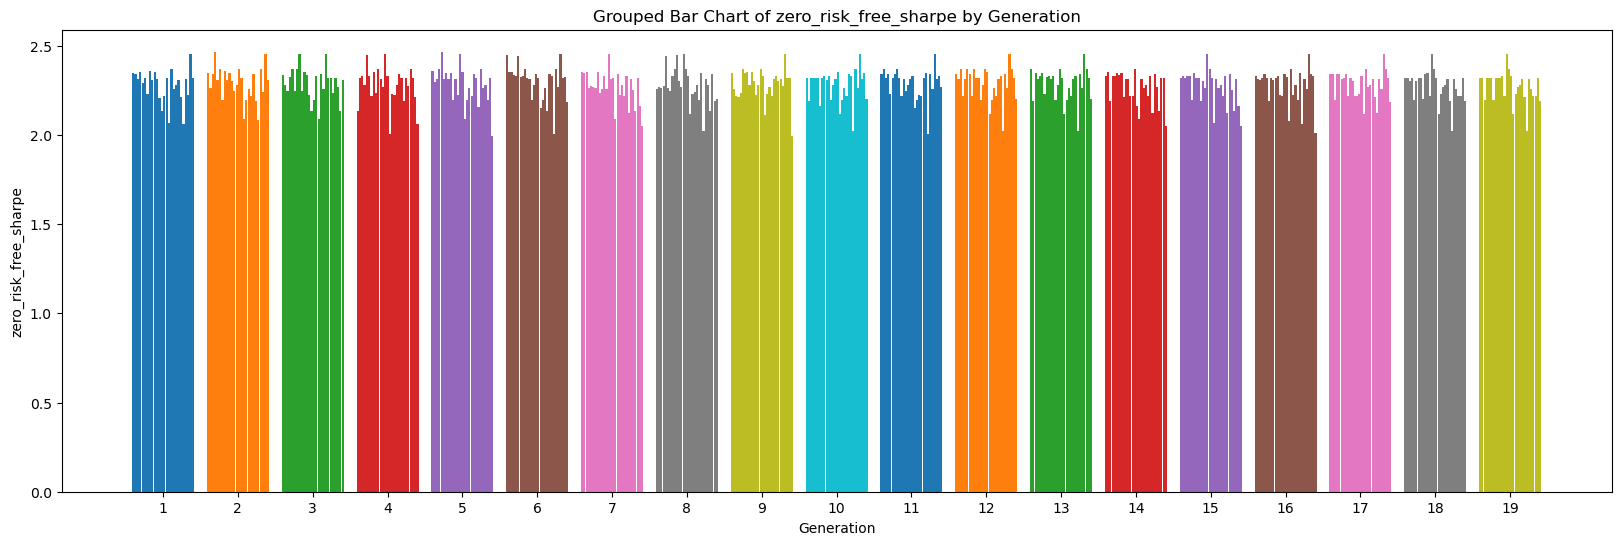

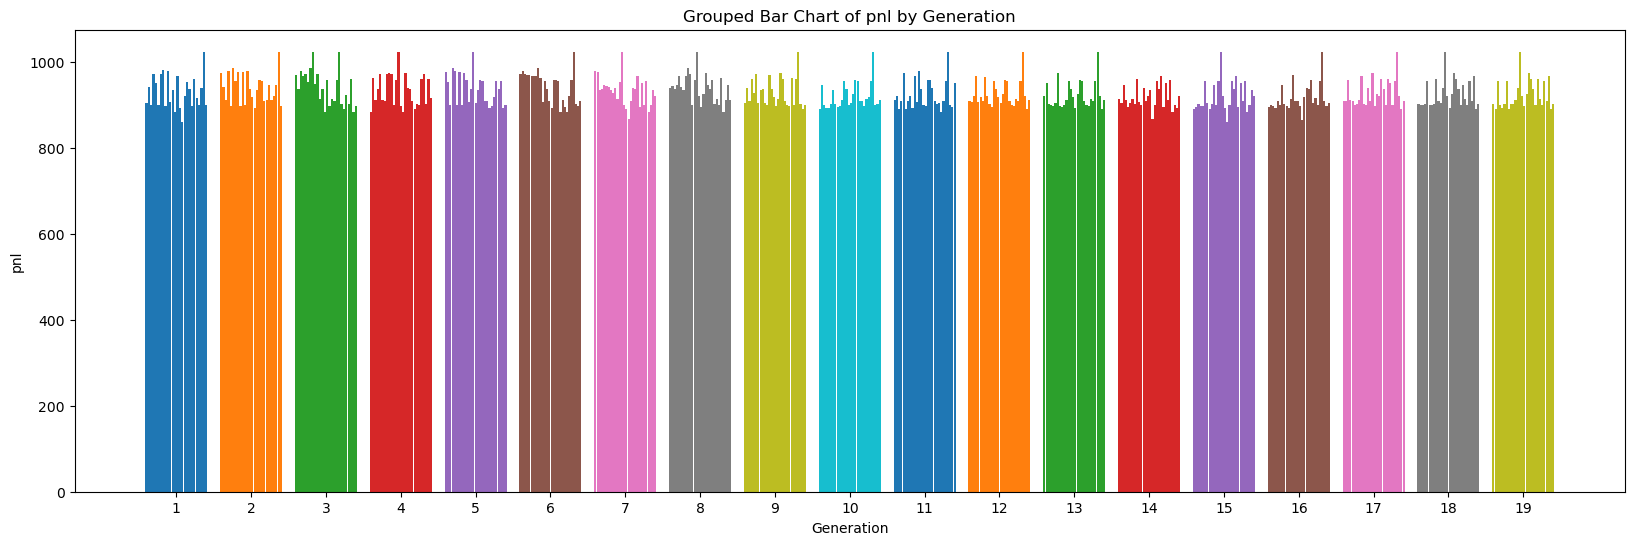

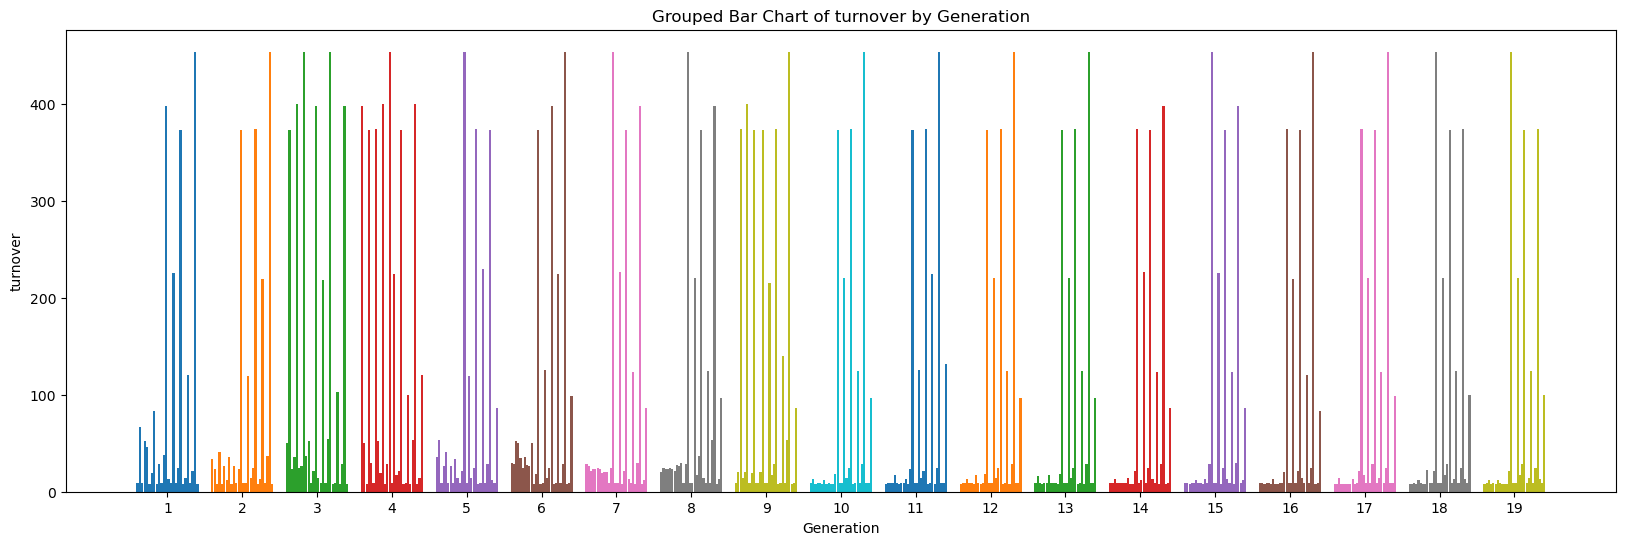

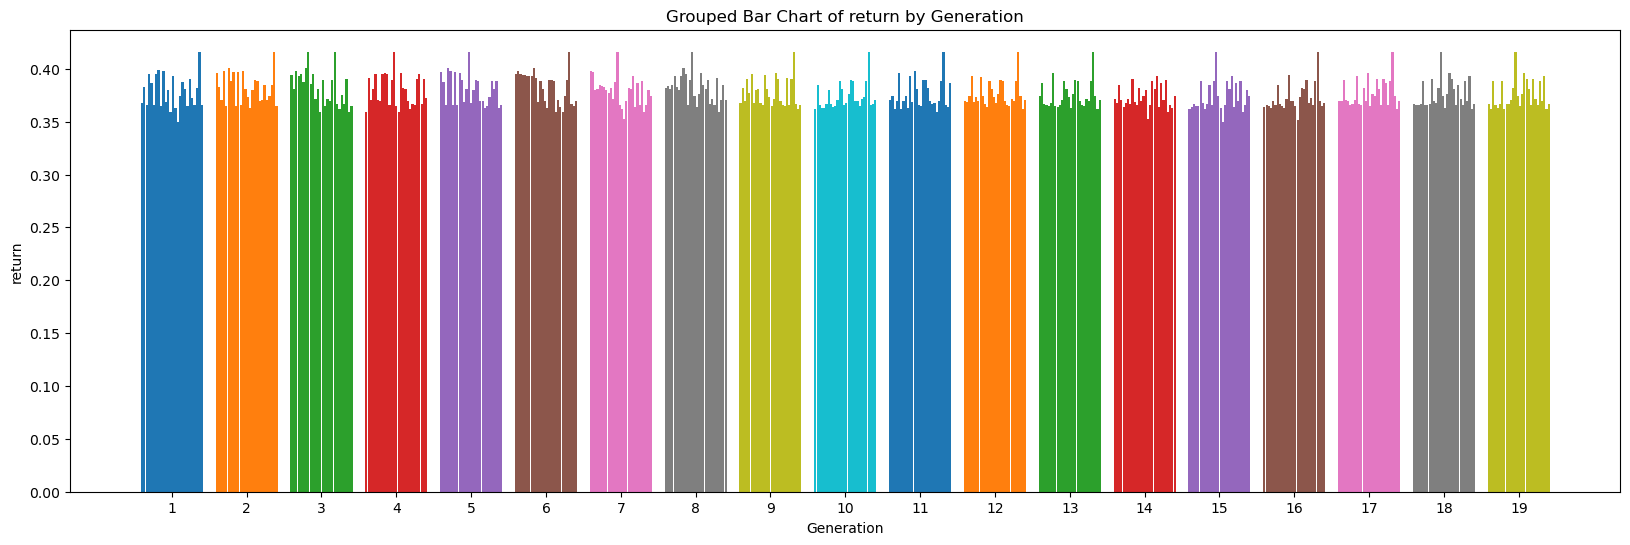

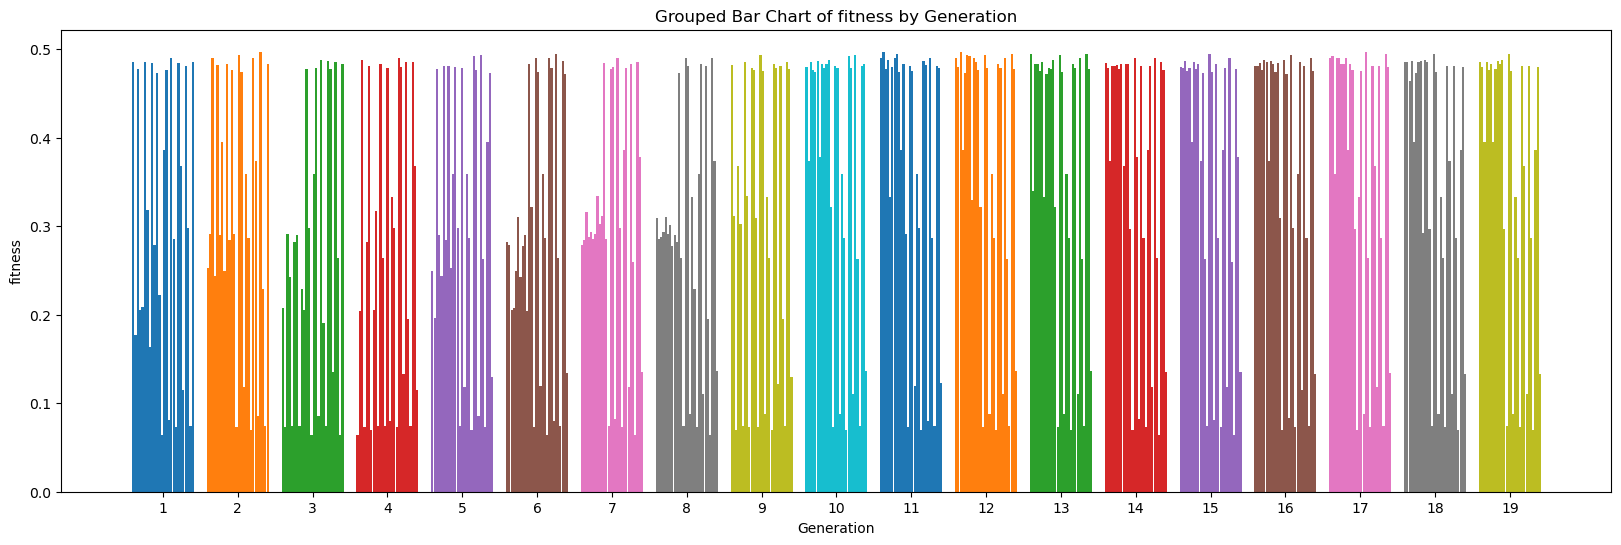

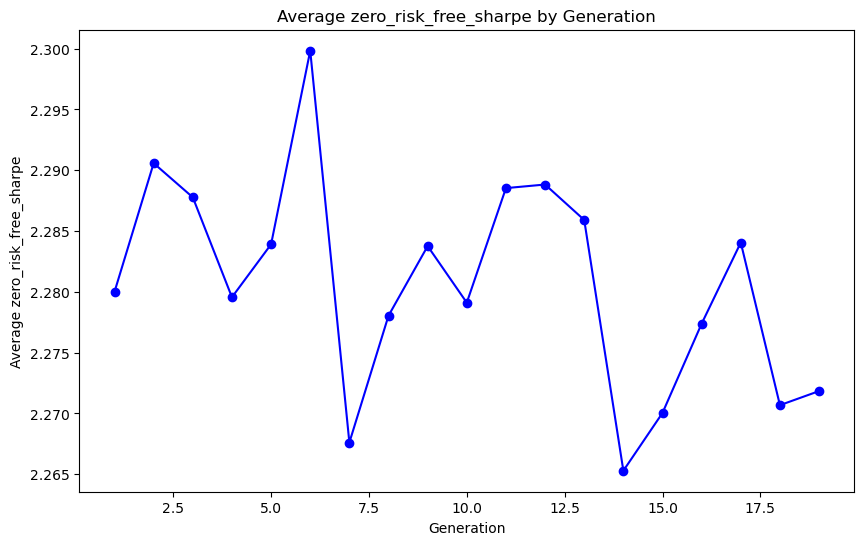

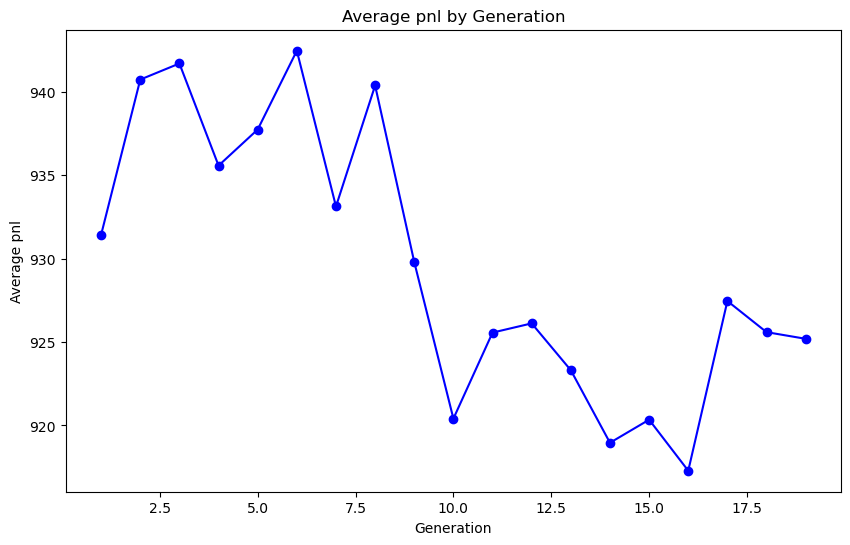

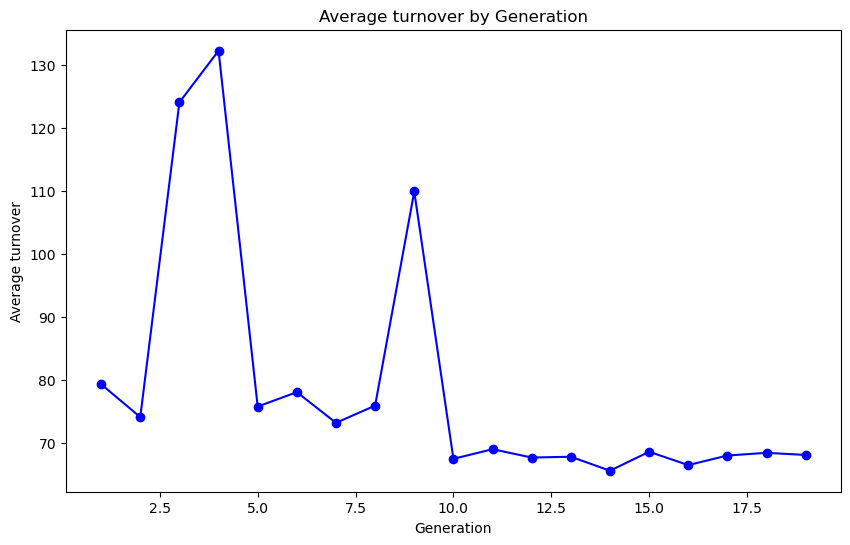

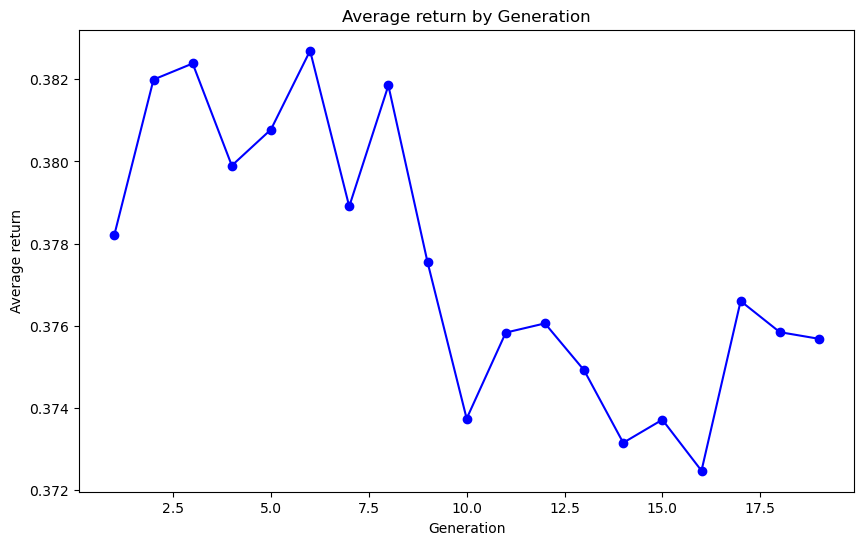

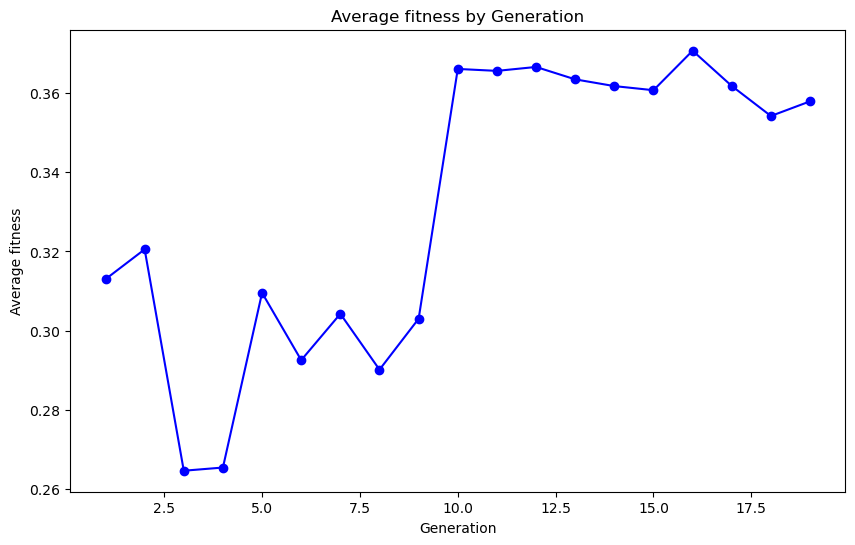

In [22]:
data = []

for metric in metric_generations:
    # Extracting the relevant keys from the inner dictionary
    for key, value in metric.items():
        data.append({
            'generation': value['generation'],
            'zero_risk_free_sharpe': value['zero risk-free sharpe'],
            'pnl': value['pnl'],
            'alpha': value['alpha'],
            'turnover': value['turnover'],
            'return': value['return'],
            'fitness': value['fitness'],
            'margin': value['margin']
        })

df = pd.DataFrame(data)
# Remove rows where 'generation' is 0
df = df[df['generation'] != 0]
df.reset_index(drop=True, inplace=True)

def visualize_bar_chart(evaluation_metric):
    
    plt.figure(figsize=(20, 6))
    unique_generations = df['generation'].unique()
    group_positions = np.arange(len(unique_generations))

    # Width of bars
    bar_width = 0.8

    # Plot the bars for each generation
    for i, gen in enumerate(unique_generations):
        # Filter data for the current generation
        gen_data = df[df['generation'] == gen].reset_index(drop=True)

        # Create x-axis positions for the bars of this generation, centered around the group position
        positions = group_positions[i] + np.linspace(-bar_width/2, bar_width/2, len(gen_data))

        # Plot individual bars for the current generation
        plt.bar(positions, gen_data[evaluation_metric], width=bar_width/len(gen_data), label=f'{gen}')

    # Add labels and title
    plt.xlabel('Generation')
    plt.ylabel(evaluation_metric)
    plt.title('Grouped Bar Chart of ' + evaluation_metric + ' by Generation')

    # Add custom x-ticks with the generation labels
    plt.xticks(group_positions, [f'{gen}' for gen in unique_generations])

    # Show the plot
    plt.show()
    return None

def visualize_line_chart(evaluation_metric):
    # Group by 'generation' and calculate the mean of 'zero_risk_free_sharpe'
    generation_avg = df.groupby('generation')[evaluation_metric].mean().reset_index()

    # Create a line chart
    plt.figure(figsize=(10, 6))
    plt.plot(generation_avg['generation'], generation_avg[evaluation_metric], marker='o', linestyle='-', color='b')

    # Adding labels and title
    plt.xlabel('Generation')
    plt.ylabel('Average ' + evaluation_metric)
    plt.title('Average ' + evaluation_metric + ' by Generation')

    # Show the plot
    plt.show()

visualize_bar_chart('zero_risk_free_sharpe')
visualize_bar_chart('pnl')
visualize_bar_chart('turnover')
visualize_bar_chart('return')
visualize_bar_chart('fitness')

visualize_line_chart('zero_risk_free_sharpe')
visualize_line_chart('pnl')
visualize_line_chart('turnover')
visualize_line_chart('return')
visualize_line_chart('fitness')


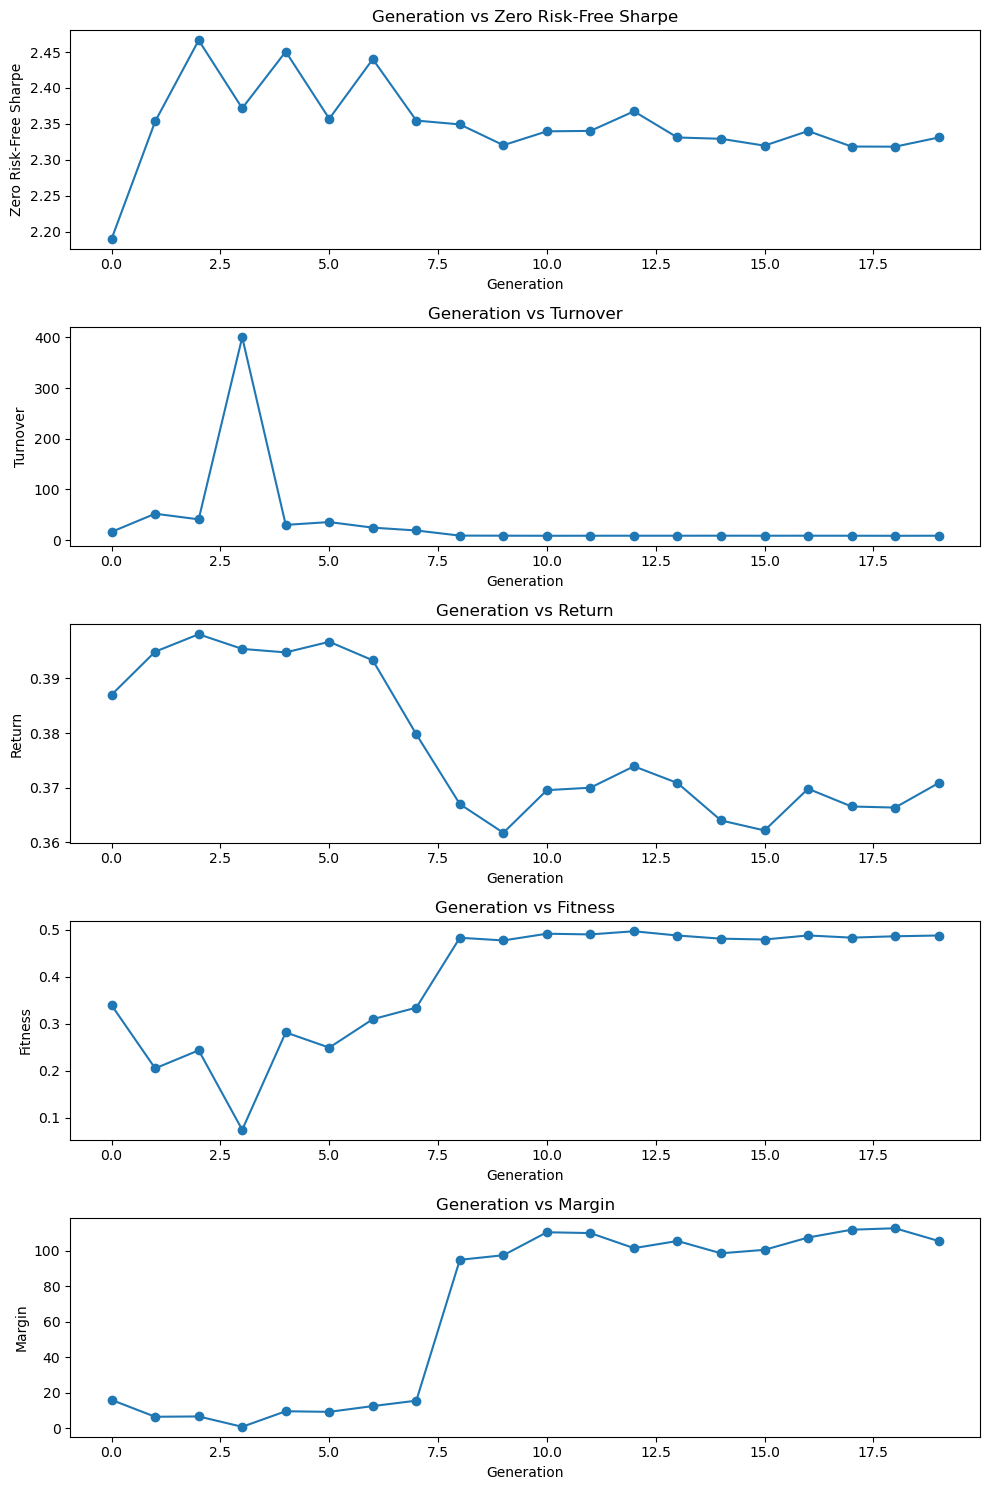

In [23]:
## Data Visualization for Top Performers
# Extract data for each metric
generations = []
sharpe = []
turnover = []
returns = []
fitness = []
margin = []
alpha = []

for performer in top_performers[1:]:
    for key, value in performer.items():
        generations.append(value["generation"])
        sharpe.append(value["zero risk-free sharpe"])
        turnover.append(value["turnover"])
        returns.append(value["return"])
        fitness.append(value["fitness"])
        margin.append(value["margin"])
        alpha.append(value["alpha"])

# Create subplots for each metric
fig, axs = plt.subplots(5, 1, figsize=(10, 15))

# Plot each metric against generation
axs[0].plot(generations, sharpe, marker='o')
axs[0].set_title('Generation vs Zero Risk-Free Sharpe')
axs[0].set_xlabel('Generation')
axs[0].set_ylabel('Zero Risk-Free Sharpe')

axs[1].plot(generations, turnover, marker='o')
axs[1].set_title('Generation vs Turnover')
axs[1].set_xlabel('Generation')
axs[1].set_ylabel('Turnover')

axs[2].plot(generations, returns, marker='o')
axs[2].set_title('Generation vs Return')
axs[2].set_xlabel('Generation')
axs[2].set_ylabel('Return')

axs[3].plot(generations, fitness, marker='o')
axs[3].set_title('Generation vs Fitness')
axs[3].set_xlabel('Generation')
axs[3].set_ylabel('Fitness')

axs[4].plot(generations, margin, marker='o')
axs[4].set_title('Generation vs Margin')
axs[4].set_xlabel('Generation')
axs[4].set_ylabel('Margin')

# Adjust layout
plt.tight_layout()
plt.show()

In [18]:
top_performers

[{"(rank(ts_min(field('close'), 10)))": {'pnl_history': date
   2016-03-11      0.000000
   2016-03-14      0.000000
   2016-03-15      0.000000
   2016-03-16      0.000000
   2016-03-17      0.000000
                    ...    
   2021-02-04    888.870029
   2021-02-05    904.394341
   2021-02-08    908.089196
   2021-02-09    911.568359
   2021-02-10    918.584533
   Name: pnl, Length: 1239, dtype: float64,
   'generation': 0,
   'zero risk-free sharpe': 2.375048145972605,
   'pnl': 918.5845334277857,
   'alpha': "(rank(ts_min(field('close'), 10)))",
   'turnover': 8.762298633727873,
   'return': 0.3729994450633671,
   'fitness': 0.490024151605249,
   'margin': 89.50457165789581}},
 {"(rank(ts_min(delta(field('volume'), 1), 10)))": {'pnl_history': date
   2016-03-11      0.000000
   2016-03-14      0.000000
   2016-03-15      0.000000
   2016-03-16      0.000000
   2016-03-17      0.000000
                    ...    
   2021-02-04    950.808173
   2021-02-05    966.913429
   2021-02-

## Statistical Analysis

In [ ]:
generations = []
sharpe = []
turnover = []
returns = []
fitness = []
margin = []
alpha = []

for performer in top_performers[1:]:
    for key, value in performer.items():
        generations.append(value["generation"])
        sharpe.append(value["zero risk-free sharpe"])
        turnover.append(value["turnover"])
        returns.append(value["return"])
        fitness.append(value["fitness"])
        margin.append(value["margin"])
        alpha.append(value["alpha"])

generations = np.array(generations)

def ols(y_value):
    sharpe = np.array(y_value)
    # Add a constant to the independent variable (generations)
    X = sm.add_constant(generations)
    
    # Perform OLS regression
    model = sm.OLS(sharpe, X)
    results = model.fit()

    # Print the regression summary
    print(results.summary())

    # Conduct F-test (null hypothesis: slope is equal to 0)
    f_test = results.f_test("x1 = 0")
    print(f_test)
    
print("Model: Sharpe = Generation * x + constant")
ols(sharpe)

print("Model: Turnover = Generation * x + constant")
ols(turnover)

print("Model: Returns = Generation * x + constant")
ols(returns)

print("Model: Fitness = Generation * x + constant")
ols(fitness)

print("Model: margin = Generation * x + constant")
ols(margin)

In [ ]:
df
# Group by 'generation' and apply the ranking within each group
df['zero_risk_free_sharpe_rank'] = df.groupby('generation')['zero_risk_free_sharpe'].rank(ascending=False)
df['turnover_rank'] = df.groupby('generation')['turnover'].rank(ascending=True)
df['rank_sum'] = df['turnover_rank'] + df['zero_risk_free_sharpe_rank'] 
# Display the updated dataframe

# Sort the dataframe by 'generation' and 'rank_sum'
df_sorted = df.sort_values(by=['generation', 'rank_sum'], ascending=[True, True])

# For each generation, get the two entries with the lowest 'rank_sum'
df_lowest_rank_sum = df_sorted.groupby('generation').head(2)

# Display the new table
df_lowest_rank_sum.reset_index(drop=True, inplace=True)
df_lowest_rank_sum

In [ ]:
#Save dictionary
np.save('messages_history.npy', messages_history) 
np.save('metric_generations.npy', metric_generations) 
np.save('top_performers.npy', top_performers) 
np.save('second_performers.npy', second_performers) 
np.save('third_performers.npy', third_performers) 

In [ ]:
deprecated = 75
messages_history[:deprecated]
metric_generations[:deprecated]
top_performers[:deprecated]
second_performers[:deprecated]
third_performers[:deprecated]

## Validation

In [ ]:
#Backtest start date, not inclusive
backtest_start = pd.Timestamp("2021-02-11")

#Backtest end date, inclusive
backtest_end = pd.Timestamp("2022-09-29")

#Maximum amount of stocks to include in backtest
max_stock = 1000

#Find the directory of the csv Files
#Default csv files stores in folder called sp500
path = os.getcwd() + "/sp500"
csv_files = glob.glob(os.path.join(path, "*.csv"))

#Column names
#Used for compatibility reasons with different data sources.
date_col = "Date"
open_col = "open"

#Minimum price
#Sometimes, stock trade at such low value that price is 0 within data accuracy
#Leads to division by 0 problem
#Can require stock to trade above some value, otherwise discard trading day
min_price = 0.01
book_value = 1e3


#################################################################
#The data frame will be stored in tickers_df
#A dictionary with key:value as (ticker:df)
tickers_df = {}

#Read data
stock_count = 0
tickers = []

#READ IN THE FILES ONE BY ONE
for path in csv_files[:max_stock]:
    #Obtain tickers
    name = path.split("/")[-1]
    name = name[:len(name)-4]
    name = name.lower()
    
    #Read the data frame. Ensure recent dates are at bottom rows
    df = pd.read_csv(path, parse_dates = [date_col], dayfirst = False)
    if df.loc[:,date_col][0] > df.loc[:,date_col][10]:
        df = df.iloc[::-1]
    
    #Change all column names to lower case for consistency
    df.columns = df.columns.str.lower()
    
    #Filter out dates before or after backtesting date
    df = df[df[date_col.lower()] > backtest_start]
    df = df[df[date_col.lower()] < backtest_end]
    
    #Set date as index, remove from df
    df.index = df[date_col.lower()]
    df = df.drop(columns = [date_col.lower()])
    
    #Read the data frame. Filter out days when prices are below threshold
    df = df[df[open_col.lower()] > min_price]
    
    #Calculate essential fields - daily returns
    if "returns" not in df.columns:
        df["returns"] = (df["open"]-df["open"].shift(1))/df["open"].shift(1)
        
    #Calculate eseential fields - adv20
    #Average volume of the past 20 days
    if "adv20" not in df.columns:
        df["adv20"] = df["volume"].rolling(20).mean()
    
    #Drop dataframe if no entries are left.
    #Will not be included in tickers_df
    row, column = df.shape
    if row != 0:
        tickers.append(name)
        tickers_df[name] = df
        stock_count += 1
    else:
        print(name, " does not have valid trading days")

#Identify All Fields Present, Used in alpha processing
fields = []
for ticker in tickers:
    columns = tickers_df[ticker].columns
    for column in columns:
        if column not in fields: 
            fields.append(column.lower())

#Report Output
print("------------------------------------------")
print(len(csv_files), " files in the directory")
print(stock_count, " stocks is used")

In [ ]:
#Run Backtest on Best Performing Alpha
#Extract the best performing alphas
top_performers_alpha = [list(metrics.keys())[0] for metrics in top_performers]
second_performers_alpha = [list(metrics.keys())[0] for metrics in second_performers]
third_performers_alpha = [list(metrics.keys())[0] for metrics in third_performers]

def test_alpha(idea):
    output = idea.split("\n")
    pattern = r'Alpha#\d+:'
    output = [re.sub(pattern, '', string).strip() for string in output]
    return run_backtest(output,1)

In [ ]:
#Save dictionary
np.save('top_performers_alpha.npy', top_performers_alpha) 
np.save('second_performers_alpha.npy', second_performers_alpha) 
np.save('third_performers_alpha.npy', third_performers_alpha) 

In [ ]:
top_performers_alpha = np.load("/Users/andrew/Desktop/UChicago/AlphaGen/08_31_1_50G_Reverie/100G/top_performers_alpha.npy", allow_pickle=True)
top_performers_alpha = top_performers_alpha[:75]

In [ ]:
gen_count = len(top_performers_alpha)
best_performer_validation = []
for i in range(gen_count):
    metric = test_alpha(top_performers_alpha[i])
    best_performer_validation.append(metric)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette("hls", 5)
# Set a style that is commonly used in research papers
sns.set_style("whitegrid", {'axes.grid' : False})
# Extract data for each metric
generations = range(1,76)
sharpe = []
turnover = []
returns = []
fitness = []
margin = []
alpha = []

for performer in best_performer_validation:
    for key, value in performer.items():
        sharpe.append(value["zero risk-free sharpe"])
        turnover.append(value["turnover"])
        returns.append(value["return"])
        fitness.append(value["fitness"])
        margin.append(value["margin"])
        alpha.append(value["alpha"])

# Create subplots for each metric
fig, axs = plt.subplots(5, 1, figsize=(10, 18))

# Plot each metric against generation
axs[0].plot(generations, sharpe, marker='o', linestyle='-', color=color[0], label='Sharpe Ratio')
axs[0].set_title('Generation vs Zero Risk-Free Sharpe', fontsize=14)
axs[0].set_xlabel('Generation', fontsize=12)
axs[0].set_ylabel('Zero Risk-Free Sharpe', fontsize=12)
axs[0].legend(loc='best')
axs[0].grid(False)

axs[1].plot(generations, turnover, marker='o', linestyle='-', color=color[1], label='Turnover')
axs[1].set_title('Generation vs Turnover', fontsize=14)
axs[1].set_xlabel('Generation', fontsize=12)
axs[1].set_ylabel('Turnover', fontsize=12)
axs[1].legend(loc='best')
axs[1].grid(False)

axs[2].plot(generations, returns, marker='o', linestyle='-', color=color[2], label='Returns')
axs[2].set_title('Generation vs Return', fontsize=14)
axs[2].set_xlabel('Generation', fontsize=12)
axs[2].set_ylabel('Return', fontsize=12)
axs[2].legend(loc='best')
axs[2].grid(False)

axs[3].plot(generations, fitness, marker='o', linestyle='-', color=color[3], label='Fitness')
axs[3].set_title('Generation vs Fitness', fontsize=14)
axs[3].set_xlabel('Generation', fontsize=12)
axs[3].set_ylabel('Fitness', fontsize=12)
axs[3].legend(loc='best')
axs[3].grid(False)

axs[4].plot(generations, margin, marker='o', linestyle='-', color=color[4], label='Margin')
axs[4].set_title('Generation vs Margin', fontsize=14)
axs[4].set_xlabel('Generation', fontsize=12)
axs[4].set_ylabel('Margin', fontsize=12)
axs[4].legend(loc='best')
axs[4].grid(False)

# Adjust layout
plt.tight_layout()

# Save the figure with a high resolution
plt.savefig('top_performers_metrics_validation.png', dpi=500)

# Display the plot
plt.show()


In [ ]:
generations = np.array(generations)

def ols(y_value):
    sharpe = np.array(y_value)
    # Add a constant to the independent variable (generations)
    X = sm.add_constant(generations)
    
    # Perform OLS regression
    model = sm.OLS(sharpe, X)
    results = model.fit()

    # Print the regression summary
    print(results.summary())

    # Conduct F-test (null hypothesis: slope is equal to 0)
    f_test = results.f_test("x1 = 0")
    print(f_test)
    
print("Model: Sharpe = Generation * x + constant")
ols(sharpe)

print("Model: Turnover = Generation * x + constant")
ols(turnover)

print("Model: Returns = Generation * x + constant")
ols(returns)

print("Model: Fitness = Generation * x + constant")
ols(fitness)

print("Model: margin = Generation * x + constant")
ols(margin)

# User Input

In [ ]:
messages = []

system_prompt = """You are a finance professional with background in economics and quantitative finance. 
Please direct your response in the form of fast expression language, as presented below"""

first_response = """
rank(): This orders the data points from highest to lowest and assigns a rank.
delta(): This calculates the change between the current and a prior element.
ts_rank(): Time-series rank over a specified window.
ts_min() and ts_max(): Time-series minimum and maximum over a specified window.
ts_sum(): Summation over a specified window.
ts_stdev(): Standard deviation over a specified window.
correlation(): Statistical correlation between two time-series.
covariance(): Measures the directional relationship between two time-series.
absolute(): Absolute value.
close, open, high, low, volume: These are typical market data points."""

first_input = """
Here are some example "alphas", written in fast expression language.
Alphas are algorithmic strategies that will provide return higher than the market. 
Learn the fast expression language, using available data fields

Alpha#1: (-1 * correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6)) 
Alpha#2: (-1 * correlation(rank(open), rank(volume), 10))
Alpha#3: (-1 * Ts_Rank(rank(low), 9))
Alpha#4: (-1 * correlation(open, volume, 10))
Alpha#5: (-1 * rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - delay((ts_sum(open, 5) * ts_sum(returns, 5)), 10))))
Alpha#6: (sign(delta(volume, 1)) * (-1 * delta(close, 1)))
Alpha#7: (-1 * rank(covariance(rank(close), rank(volume), 5)))
Alpha#8: ((-1 * rank(delta(returns, 3))) * correlation(open, volume, 10))
Alpha#9: (-1 * ts_sum(rank(correlation(rank(high), rank(volume), 3)), 3))
Alpha#10: (-1 * rank(covariance(rank(high), rank(volume), 5)))
Alpha#11: (((-1 * rank(ts_rank(close, 10))) * rank(delta(delta(close, 1), 1))) * rank(ts_rank((volume / adv20), 5)))
Alpha#12: (-1 * rank(((ts_stdev(absolute((close - open)), 5) + (close - open)) + correlation(close, open, 10))))
Alpha#13: ((-1 * sign(((close - delay(close, 7)) + delta(close, 7)))) * (1 + rank((1 + ts_sum(returns, 250)))))
Alpha#14: (((-1 * rank((open - delay(high, 1)))) * rank((open - delay(close, 1)))) * rank((open - delay(low, 1))))

The user is going to describe their trading idea in natural language. I want you to return the idea in the language of fast expression.
MAKE SURE THE RESPONSE YOU GIVE IS IN THE FOLLOWING FORMAT:
It should begin with "Alpha#xx"
Followed by a colon
And then a specific type of command or formula related to financial analysis.
"""

second_input = inp = input('Input your alpha idea')

messages.append({"role": "system",
                 "content": system_prompt})
messages.append({"role": "user",
                 "content": first_input})
messages.append({"role": "assistant",
                 "content": first_response})
messages.append({"role": "user",
                 "content": second_input})

output = openai.ChatCompletion.create(
  model="gpt-4",
  messages=messages,
  temperature=0,
  max_tokens=1024
)

#Here is the output of GPT4
output = output["choices"][0]["message"]["content"]
messages.append({"role": "assistant",
                 "content": output})

#Process the output. Result the ALpha#: prefix. Split by new line
output = output.split("\n")
pattern = r'Alpha#\d+:'
output = [re.sub(pattern, '', string).strip() for string in output]
